In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.fid import *

In [ ]:
set_seed(1103, False)
mpl.rcParams['image.cmap'] = 'gray'
logging.disable(logging.WARNING)

In [ ]:
fm_x, fm_y = "image", "label"
name = "fashion_mnist"
ds = load_dataset(name)

In [ ]:
@inplace
def transformi(b):
    b["image"] = [TF.pad(TF.to_tensor(i), padding=2, fill=0, padding_mode="constant") - 0.5 for i in b["image"]]
dst = ds.with_transform(transformi)

bs = 64
dls = DataLoaders.from_dd(dst, bs)
xb, yb = next(iter(dls.train))
xb.min(), xb.max()

(tensor(-0.5000), tensor(0.5000))

In [ ]:
class Schedule:
    def __init__(self, alphas, betas, alphas_bar, sigmas, n_steps):
        fc.store_attr()

In [ ]:
def linear_sched(beta_min=0.0001, beta_max=0.02, n_steps=1000):
    betas = torch.linspace(beta_min, beta_max, n_steps)
    alphas = 1 - betas
    alphas_bar = torch.cumprod(alphas, 0)
    sigmas = betas.sqrt()
    return Schedule(alphas, betas, alphas_bar, sigmas, n_steps)

In [ ]:
def abar(t, T):
    return ((t / T) * (math.pi / 2)).cos() ** 2

In [ ]:
torch.linspace(0, 4, 5)

tensor([0., 1., 2., 3., 4.])

In [ ]:
s = linear_sched(n_steps=5)
s.alphas, s.alphas_bar

(tensor([0.9999, 0.9949, 0.9900, 0.9850, 0.9800]),
 tensor([0.9999, 0.9948, 0.9848, 0.9700, 0.9506]))

https://arxiv.org/abs/2102.09672

In [ ]:
def cos_sched(n_steps=1000):
    t = torch.linspace(0, n_steps - 1, n_steps)
    alphas_bar = abar(t, n_steps)
    alphas = alphas_bar.clone()
    alphas[1:] /= alphas_bar[:-1]
    betas = 1 - alphas
    betas = torch.clip(betas, max=0.999)
    sigmas = betas.sqrt()

    return Schedule(alphas, betas, alphas_bar, sigmas, n_steps)

In [ ]:
s = cos_sched(5)
s.alphas, s.alphas_bar

(tensor([1.0000, 0.9045, 0.7236, 0.5279, 0.2764]),
 tensor([1.0000, 0.9045, 0.6545, 0.3455, 0.0955]))

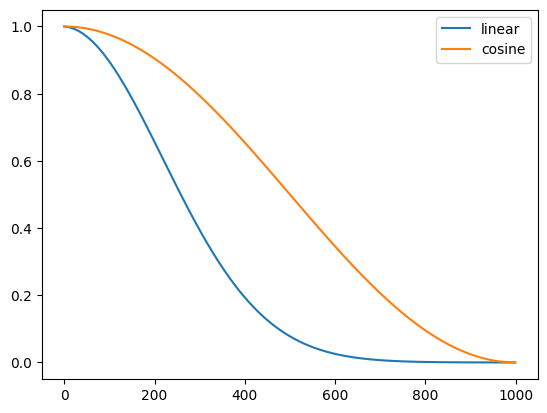

In [ ]:
linear_alphas_bar = linear_sched().alphas_bar
cosine_alphas_bar = cos_sched().alphas_bar
plt.plot(linear_alphas_bar, label="linear")
plt.plot(cosine_alphas_bar, label="cosine")
plt.legend();

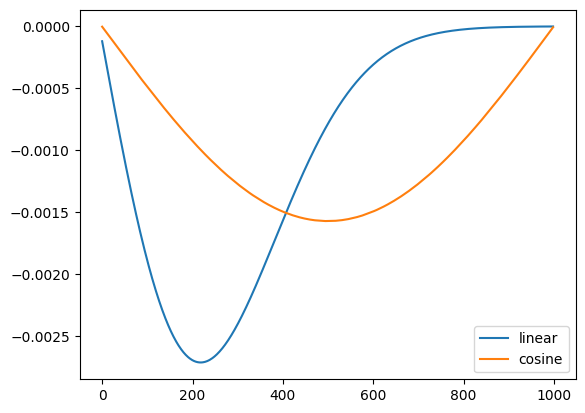

In [ ]:
plt.plot(linear_alphas_bar[1:] - linear_alphas_bar[:-1], label="linear")
plt.plot(cosine_alphas_bar[1:] - cosine_alphas_bar[:-1], label="cosine")
plt.legend();

In [ ]:
linear_sched

<function __main__.linear_sched(beta_min=0.0001, beta_max=0.02, n_steps=1000)>

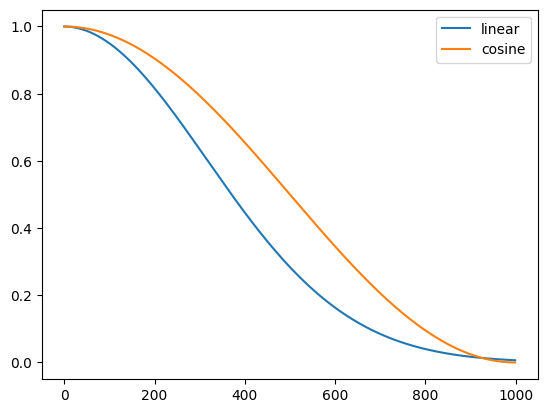

In [ ]:
linear_alphas_bar = linear_sched(beta_min=0.00001, beta_max=0.01).alphas_bar
plt.plot(linear_alphas_bar, label="linear")
plt.plot(cosine_alphas_bar, label="cosine")
plt.legend();

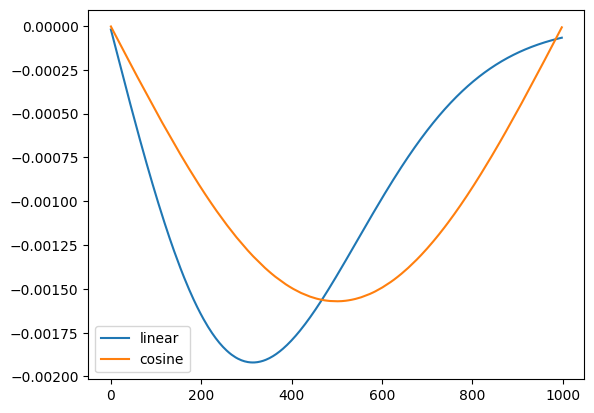

In [ ]:
plt.plot(linear_alphas_bar[1:] - linear_alphas_bar[:-1], label="linear")
plt.plot(cosine_alphas_bar[1:] - cosine_alphas_bar[:-1], label="cosine")
plt.legend();

In [ ]:
schedule = linear_sched(beta_min=0.00001, beta_max=0.01)

# Training

In [ ]:
from diffusers import UNet2DModel

In [ ]:
def add_noise(x, schedule=schedule):
    device = x.device
    bs = x.shape[0]

    t = torch.randint(0, schedule.n_steps, (bs,), dtype=torch.int64)
    alpha_bar_t = schedule.alphas_bar[t][:, None, None, None].to(device)
    
    original_part = alpha_bar_t.sqrt() * x
    epsilon = torch.randn(x.shape, device=device)
    noise_part = (1 - alpha_bar_t).sqrt() * epsilon

    xt = original_part + noise_part
    return (xt, t.to(device)), epsilon

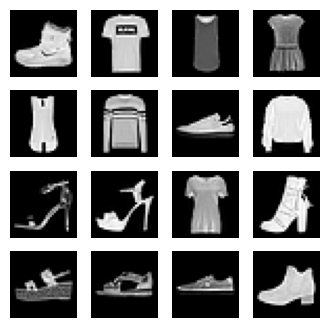

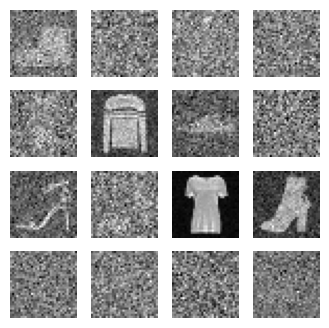

In [ ]:
show_images(xb[:16]+0.5, imsize=1)
show_images(add_noise(xb[:16])[0][0]+0.5, imsize=1);

In [ ]:
def get_collate_ddpm(schedule=schedule):
    def _collate_ddpm(b):
        return add_noise(default_collate(b)[fm_x], schedule)
    return _collate_ddpm

collate_ddpm = get_collate_ddpm(schedule)

In [ ]:
def dl_ddpm(ds):
    return DataLoader(ds, batch_size=bs*2, collate_fn=collate_ddpm, num_workers=4)

In [ ]:
class UNet(UNet2DModel):
    def forward(self, x):
        return super().forward(*x).sample

In [ ]:
def init_ddpm(model):
    for down_block in model.down_blocks:
        for resnet in down_block.resnets:
            resnet.conv2.weight.data.zero_()
        downsamplers = down_block.downsamplers
        if not downsamplers: downsamplers = []
        for downsampler in downsamplers:
            init.orthogonal_(downsampler.conv.weight)

    model.conv_out.weight.data.zero_()

In [ ]:
dls = DataLoaders(dl_ddpm(dst["train"]), dl_ddpm(dst["test"]))

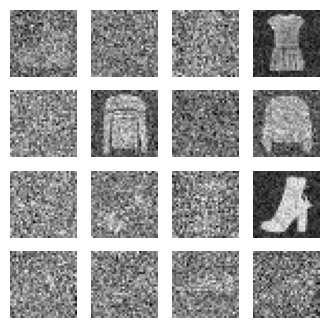

In [ ]:
xb, yb = next(iter(dls.train))
show_images(xb[0][:16], imsize=1);

loss,epoch,train
0.325,0,train
0.044,0,valid
0.038,1,train
0.034,1,valid
0.033,2,train
0.031,2,valid
0.030,3,train
0.030,3,valid
0.029,4,train
0.029,4,valid


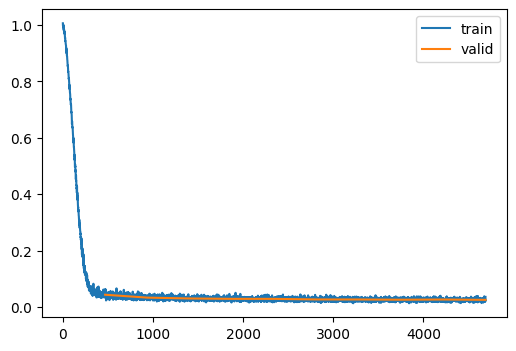

In [ ]:
set_seed(1103, False)
lr = 0.001
epochs = 10
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))
cbs = [DeviceCB(), ProgressCB(True), MetricsCB(), sched]

model = UNet(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 256), norm_num_groups=16)
init_ddpm(model)

opt_func = partial(optim.AdamW, eps=1e-4)

learn = TrainLearner(model, dls, F.mse_loss, lr=lr, cbs=cbs, opt_func=opt_func)
learn.fit(epochs)

In [ ]:
model_path = Path("models")
model_path.mkdir(exist_ok=True)
torch.save(learn.model, model_path / "19_ddpm_v3_lincos_10.pkl")

# Sampling

In [ ]:
model_path = Path("models")
model = torch.load(model_path / "19_ddpm_v3_lincos_10.pkl")

In [ ]:
def sample(model, sz, schedule=schedule, minv=-0.5, maxv=0.5):
        device = next(model.parameters()).device
        with torch.no_grad():
            x = torch.randn(sz, device=device)
            bs = x.shape[0]
            process = []
    
            for t in reversed(range(schedule.n_steps)):
                t_batch = torch.full((bs,), t, dtype=torch.int64)
    
                # Repametrized equation (4)
                noise_pred = model((x, t_batch.to(device)))
                alpha_bar_t = schedule.alphas_bar[t]
                x0_est = (x - (1 - alpha_bar_t).sqrt() * noise_pred) * (1 / alpha_bar_t.sqrt())
                x0_est = x0_est.clamp(minv, maxv)
    
                # Equations (7) and (8)
                alpha_bar_t_minus_1 = torch.tensor(1) if t == 0 else schedule.alphas_bar[t - 1]
                x0_coef = alpha_bar_t_minus_1.sqrt() * schedule.betas[t] / (1 - alpha_bar_t)
                xt_coef = schedule.alphas[t].sqrt() * (1 - alpha_bar_t_minus_1) / (1 - alpha_bar_t)
                noise_sample = torch.zeros(x.shape, device=device) if t == 0 else torch.randn(x.shape, device=device)
                x = x0_coef * x0_est + x * xt_coef + schedule.sigmas[t] * noise_sample
    
                process.append(to_cpu(x))
    
        return process

In [ ]:
%%time
samples = sample(model, (128, 1, 32, 32))

CPU times: user 15min 50s, sys: 1.05 s, total: 15min 51s
Wall time: 15min 51s


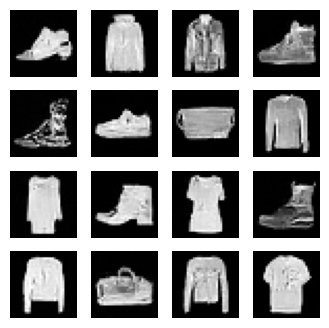

In [ ]:
final = (samples[-1] * 2)
show_images(final[:16], imsize=1);

In [ ]:
@inplace
def transformi2(b):
    b["image"] = [TF.pad(TF.to_tensor(i), padding=2, fill=0, padding_mode="constant") * 2 - 1 for i in b["image"]]
dst2 = ds.with_transform(transformi2)

dls2 = DataLoaders.from_dd(dst2, bs)

In [ ]:
fid_model = torch.load('models/14_aug_for_fid.pkl')
del fid_model[8]
del fid_model[7]

In [ ]:
image_eval = ImageEval(fid_model, dls2, cbs=[DeviceCB()])

In [ ]:
image_eval.fid(final), image_eval.kid(final)

(37.26513671875, 0.04125404357910156)

In [ ]:
dls = DataLoaders.from_dd(dst, 128)
xb, yb = next(iter(dls.train))

In [ ]:
image_eval.fid(xb * 2), image_eval.kid(xb * 2)

(28.98095703125, 0.0020194053649902344)

## Skip Sampling

In [ ]:
def skip_sample(model, sz, schedule=schedule, minv=-0.5, maxv=0.5):
        device = next(model.parameters()).device
        with torch.no_grad():
            x = torch.randn(sz, device=device)
            bs = x.shape[0]
            process = []
    
            for t in reversed(range(schedule.n_steps)):
                t_batch = torch.full((bs,), t, dtype=torch.int64)
    
                # Repametrized equation (4)
                if t == 999 or t % 2 == 0 or t < 100:
                    noise_pred = model((x, t_batch.to(device)))
                alpha_bar_t = schedule.alphas_bar[t]
                x0_est = (x - (1 - alpha_bar_t).sqrt() * noise_pred) * (1 / alpha_bar_t.sqrt())
                x0_est = x0_est.clamp(minv, maxv)
    
                # Equations (7) and (8)
                alpha_bar_t_minus_1 = torch.tensor(1) if t == 0 else schedule.alphas_bar[t - 1]
                x0_coef = alpha_bar_t_minus_1.sqrt() * schedule.betas[t] / (1 - alpha_bar_t)
                xt_coef = schedule.alphas[t].sqrt() * (1 - alpha_bar_t_minus_1) / (1 - alpha_bar_t)
                noise_sample = torch.zeros(x.shape, device=device) if t == 0 else torch.randn(x.shape, device=device)
                x = x0_coef * x0_est + x * xt_coef + schedule.sigmas[t] * noise_sample
    
                process.append(to_cpu(x))
    
        return process

In [ ]:
%%time
samples = skip_sample(model, (128, 1, 32, 32))

CPU times: user 7min 27s, sys: 470 ms, total: 7min 27s
Wall time: 7min 27s


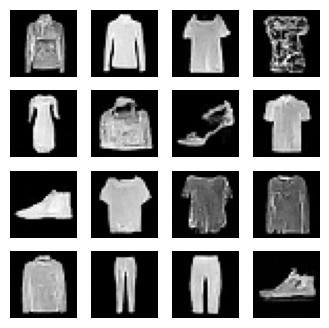

In [ ]:
final = (samples[-1] * 2)
show_images(final[:16], imsize=1);

In [ ]:
image_eval.fid(final), image_eval.kid(final)

(47.37255859375, 0.1334366798400879)

In [ ]:
def skip_sample2(model, sz, schedule=schedule, minv=-0.5, maxv=0.5):
        device = next(model.parameters()).device
        with torch.no_grad():
            x = torch.randn(sz, device=device)
            bs = x.shape[0]
            process = []
    
            for t in reversed(range(schedule.n_steps)):
                t_batch = torch.full((bs,), t, dtype=torch.int64)
    
                # Repametrized equation (4)
                if t < 50 or t in [60, 70, 80, 90, 100, 200, 500, 600, 700, 800, 900, 950, 999]:
                    noise_pred = model((x, t_batch.to(device)))
                alpha_bar_t = schedule.alphas_bar[t]
                x0_est = (x - (1 - alpha_bar_t).sqrt() * noise_pred) * (1 / alpha_bar_t.sqrt())
                x0_est = x0_est.clamp(minv, maxv)
    
                # Equations (7) and (8)
                alpha_bar_t_minus_1 = torch.tensor(1) if t == 0 else schedule.alphas_bar[t - 1]
                x0_coef = alpha_bar_t_minus_1.sqrt() * schedule.betas[t] / (1 - alpha_bar_t)
                xt_coef = schedule.alphas[t].sqrt() * (1 - alpha_bar_t_minus_1) / (1 - alpha_bar_t)
                noise_sample = torch.zeros(x.shape, device=device) if t == 0 else torch.randn(x.shape, device=device)
                x = x0_coef * x0_est + x * xt_coef + schedule.sigmas[t] * noise_sample
    
                process.append(to_cpu(x))
    
        return process

In [ ]:
%%time
samples = skip_sample2(model, (128, 1, 32, 32))

CPU times: user 35.7 s, sys: 40.1 ms, total: 35.7 s
Wall time: 35.7 s


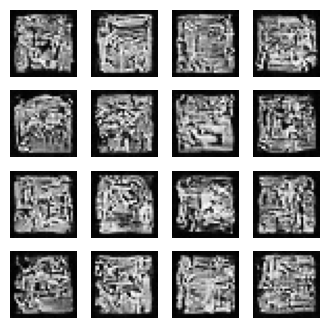

In [ ]:
final = (samples[-1] * 2)
show_images(final[:16], imsize=1);

In [ ]:
image_eval.fid(final), image_eval.kid(final)

(843.6402587890625, 6.6536455154418945)